`python3 main.py experiment=dna_multinomial training.num_epochs=10000 training.eval_interval=1000 training.save_interval=1000 training.log_interval=100`

In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from mixer.mixer import SetMixer
from datasets.synthetic_dna import SyntheticDNADataset

from torch.utils.data import DataLoader
from itertools import product

from scipy.linalg import sqrtm
import ternary

In [2]:
device = 'cuda'
configs = get_all_experiments_info('outputs/', False)
cfg = [c for c in configs if 'dna_multinomial' in c['name'] 
                    and c['config']['training']['num_epochs'] == 100000]
cfg = cfg[0]
cfg

{'name': 'dna_multinomial_b6de4f0788a762a0ee13bded40ed432c',
 'dir': 'outputs/dna_multinomial_b6de4f0788a762a0ee13bded40ed432c',
 'config': {'dataset': {'_target_': 'datasets.synthetic_dna.SyntheticDNADataset', 'num_sets': 3, 'set_size': '${experiment.set_size}', 'pattern_length': 4, 'seq_length': 10, 'num_patterns_per_set': 1, 'nucleotides': ['A', 'C', 'G', 'T'], 'max_seq_length': 12, 'seed': '${seed}'}, 'encoder': {'_target_': 'encoder.dna_conv_encoder.DNAConvEncoder', 'in_channels': 5, 'hidden_channels': 64, 'out_channels': 128, 'hidden_dim': 256, 'latent_dim': '${experiment.latent_dim}', 'num_layers': 3, 'kernel_size': 7, 'seq_length': '${dataset.max_seq_length}', 'pool_type': 'mean', 'agg_type': 'mean'}, 'model': {'_target_': 'types.NoneType'}, 'generator': {'_target_': 'generator.hyenadna_generator.HyenaDNAGenerator', 'latent_dim': '${experiment.latent_dim}', 'condition_dim': 128, 'd_model': 128, 'n_layer': 6, 'max_seq_len': '${dataset.max_seq_length}', 'condition_method': 'prefi

In [3]:
def load_model(cfg, path, device):
    enc = hydra.utils.instantiate(cfg['encoder'])
    gen = hydra.utils.instantiate(cfg['generator'])
    state = load_best_model(path)
    enc.load_state_dict(state['encoder_state_dict'])
    gen.model.load_state_dict(state['generator_state_dict'])
    enc.eval()
    gen.model.eval()
    enc.to(device)
    gen.model.to(device)
    return enc, gen

def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid


In [4]:
dataset = hydra.utils.instantiate(cfg['config']['dataset'])
mixer = hydra.utils.instantiate(cfg['config']['mixer'])
enc, gen = load_model(cfg['config'], cfg['dir'], 'cuda')

In [5]:
def recursive_collate(batch_part):
            if isinstance(batch_part[0], torch.Tensor):
                return torch.stack(batch_part)
            elif isinstance(batch_part[0], dict):
                return {key: recursive_collate([b[key] for b in batch_part]) for key in batch_part[0]}
            else:
                return batch_part  # for strings, lists, or other non-tensor data
            
collated = recursive_collate([dataset.__getitem__(i) for i in range(3)])

In [6]:
points_per_dim = 10
k = 3
set_size = 100

mix_probs_labels = simplex_grid(k, points_per_dim)

print(mix_probs_labels)

mixer = SetMixer(k=k, mixed_set_size=set_size, 
                n_mixed_sets=len(mix_probs_labels))

mixed_sets = mixer.prescribed_mixing(collated, 
                                     torch.tensor(mix_probs_labels))

[[0.         0.         1.        ]
 [0.         0.11111111 0.88888889]
 [0.         0.22222222 0.77777778]
 [0.         0.33333333 0.66666667]
 [0.         0.44444444 0.55555556]
 [0.         0.55555556 0.44444444]
 [0.         0.66666667 0.33333333]
 [0.         0.77777778 0.22222222]
 [0.         0.88888889 0.11111111]
 [0.         1.         0.        ]
 [0.11111111 0.         0.88888889]
 [0.11111111 0.11111111 0.77777778]
 [0.11111111 0.22222222 0.66666667]
 [0.11111111 0.33333333 0.55555556]
 [0.11111111 0.44444444 0.44444444]
 [0.11111111 0.55555556 0.33333333]
 [0.11111111 0.66666667 0.22222222]
 [0.11111111 0.77777778 0.11111111]
 [0.11111111 0.88888889 0.        ]
 [0.22222222 0.         0.77777778]
 [0.22222222 0.11111111 0.66666667]
 [0.22222222 0.22222222 0.55555556]
 [0.22222222 0.33333333 0.44444444]
 [0.22222222 0.44444444 0.33333333]
 [0.22222222 0.55555556 0.22222222]
 [0.22222222 0.66666667 0.11111111]
 [0.22222222 0.77777778 0.        ]
 [0.33333333 0.         0.66

In [7]:
samples = mixed_sets['samples']
for k, v in samples.items():
    if isinstance(v, torch.Tensor):
        samples[k] = v.to('cuda').to(torch.float)

with torch.no_grad():
    latent = enc(samples)
    rec = gen.sample(latent, num_samples=100, return_texts=True)
    texts = rec[1]

text shape 55 100 10


In [8]:
patterns = [p[0] for p in dataset.patterns]
ests = []
for seq_set in texts:
    compositions = [0, 0, 0]
    for seq in seq_set:
        for pattern in patterns:
            if pattern in seq:
                compositions[patterns.index(pattern)] += 1
            continue
    ests.append(np.array(compositions)/sum(compositions))

In [9]:
ests


[array([0.03, 0.01, 0.96]),
 array([0.01, 0.09, 0.9 ]),
 array([0.04, 0.2 , 0.76]),
 array([0.01, 0.26, 0.73]),
 array([0.02, 0.38, 0.6 ]),
 array([0.  , 0.56, 0.44]),
 array([0.01980198, 0.68316832, 0.2970297 ]),
 array([0.05, 0.73, 0.22]),
 array([0.01010101, 0.81818182, 0.17171717]),
 array([0.09, 0.88, 0.03]),
 array([0.15, 0.  , 0.85]),
 array([0.13, 0.09, 0.78]),
 array([0.16, 0.38, 0.46]),
 array([0.05, 0.31, 0.64]),
 array([0.09, 0.45, 0.46]),
 array([0.14, 0.58, 0.28]),
 array([0.06, 0.69, 0.25]),
 array([0.06, 0.87, 0.07]),
 array([0.08, 0.88, 0.04]),
 array([0.16, 0.01, 0.83]),
 array([0.21, 0.09, 0.7 ]),
 array([0.25, 0.24, 0.51]),
 array([0.27, 0.39, 0.34]),
 array([0.2 , 0.44, 0.36]),
 array([0.23, 0.62, 0.15]),
 array([0.16161616, 0.75757576, 0.08080808]),
 array([0.20792079, 0.79207921, 0.        ]),
 array([0.25, 0.02, 0.73]),
 array([0.27, 0.05, 0.68]),
 array([0.34, 0.29, 0.37]),
 array([0.38, 0.4 , 0.22]),
 array([0.34, 0.37, 0.29]),
 array([0.33333333, 0.54545455, 

In [10]:
def w2_multinom_pairwise(ps):
    # build pop cov matrix
    def pop_cov(x):
        n = len(x)
        c = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                c[i, j] = x[i]*(1 - x[i]) if i == j else -x[i]*x[j]
        return c

    ps = np.array(ps)
    n = len(ps)
    dists = np.zeros((n, n))

    sigs = [pop_cov(p) for p in ps]
    roots = [sqrtm(s) for s in sigs]

    for i in range(n):
        for j in range(n):
            mu_diff = np.sum((ps[i] - ps[j])**2)
            mid = sqrtm(roots[i] @ sigs[j] @ roots[i])
            if np.iscomplexobj(mid):
                mid = mid.real
            cov_diff = np.trace(sigs[i] + sigs[j] - 2*mid)
            dists[i, j] = np.sqrt(mu_diff + cov_diff)

    return dists 

In [11]:
def batched_dists(mixed_sets, mix_probs, encoder, batch_size=8, device='cuda'):

    samples = mixed_sets['samples']
    
    
    with torch.no_grad():
        
        zs = []
        for i in range(0, len(mix_probs), batch_size):

            x_chunk = {}

            for k, v in samples.items():
                if isinstance(v, torch.Tensor):
                    x_chunk[k] = v[i:i+batch_size].to('cuda').to(torch.float)
            z_chunk = encoder(x_chunk).cpu()  # offload!
            zs.append(z_chunk)
        z = torch.cat(zs, dim=0).to(device)  # full z back on gpu :)

    return w2_multinom_pairwise(mix_probs), torch.cdist(z, z, p=2)

In [12]:
def plot_ternary(ax, dists, mix_probs, title=None, scale=99):

    prob_tuples = [tuple(map(int, np.round(s * scale))) for s in mix_probs]
    print(prob_tuples)
    anchor_idx = prob_tuples.index((scale//3, scale//3, scale//3))
    # anchor_idx = 0
    colors = dists[anchor_idx]
    simplex_d = {prob_tuples[i]: colors[i] for i in range(len(prob_tuples))}

    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax.heatmap(simplex_d, style="h")
    tax.boundary()
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    if title:
        tax.set_title(title)

    # tax.scatter([prob_tuples[anchor_idx]], marker='*', color='pink', s=100, zorder=10)

/tmp/ipykernel_633621/2629716128.py:25: RuntimeWarning: invalid value encountered in sqrt
  dists[i, j] = np.sqrt(mu_diff + cov_diff)


[(0, 0, 9), (0, 1, 8), (0, 2, 7), (0, 3, 6), (0, 4, 5), (0, 5, 4), (0, 6, 3), (0, 7, 2), (0, 8, 1), (0, 9, 0), (1, 0, 8), (1, 1, 7), (1, 2, 6), (1, 3, 5), (1, 4, 4), (1, 5, 3), (1, 6, 2), (1, 7, 1), (1, 8, 0), (2, 0, 7), (2, 1, 6), (2, 2, 5), (2, 3, 4), (2, 4, 3), (2, 5, 2), (2, 6, 1), (2, 7, 0), (3, 0, 6), (3, 1, 5), (3, 2, 4), (3, 3, 3), (3, 4, 2), (3, 5, 1), (3, 6, 0), (4, 0, 5), (4, 1, 4), (4, 2, 3), (4, 3, 2), (4, 4, 1), (4, 5, 0), (5, 0, 4), (5, 1, 3), (5, 2, 2), (5, 3, 1), (5, 4, 0), (6, 0, 3), (6, 1, 2), (6, 2, 1), (6, 3, 0), (7, 0, 2), (7, 1, 1), (7, 2, 0), (8, 0, 1), (8, 1, 0), (9, 0, 0)]
[(0, 0, 9), (0, 1, 8), (0, 2, 7), (0, 3, 6), (0, 4, 5), (0, 5, 4), (0, 6, 3), (0, 7, 2), (0, 8, 1), (0, 9, 0), (1, 0, 8), (1, 1, 7), (1, 2, 6), (1, 3, 5), (1, 4, 4), (1, 5, 3), (1, 6, 2), (1, 7, 1), (1, 8, 0), (2, 0, 7), (2, 1, 6), (2, 2, 5), (2, 3, 4), (2, 4, 3), (2, 5, 2), (2, 6, 1), (2, 7, 0), (3, 0, 6), (3, 1, 5), (3, 2, 4), (3, 3, 3), (3, 4, 2), (3, 5, 1), (3, 6, 0), (4, 0, 5), (4, 1, 4

Text(0.5, 1.0, 'latent L2')

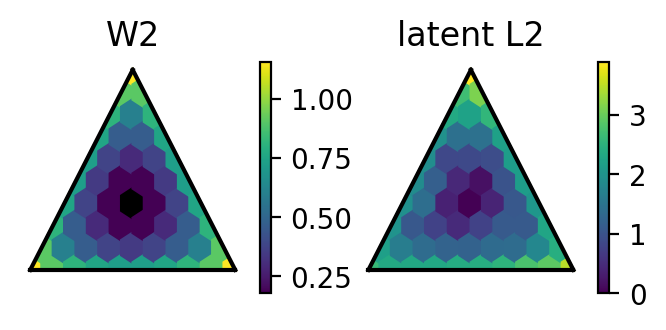

In [13]:
w, l = batched_dists(mixed_sets, 
                        mix_probs_labels, enc)

fig, axs = plt.subplots(1, 2, figsize=(4, 1.5), dpi=200)

plot_ternary(axs[0], w, mix_probs_labels, scale=9)
plot_ternary(axs[1], l.cpu(), mix_probs_labels, scale=9)
axs[0].set_title('W2')
axs[1].set_title('latent L2')

In [48]:
dataset.patterns

[['AAGC'], ['CCAA'], ['TAAA']]